In [ ]:
!pip install --upgrade pip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 13.4 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [ ]:
!pip install protobuf==3.20.0

  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.6
    Uninstalling protobuf-4.25.6:
      Successfully uninstalled protobuf-4.25.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery-storage 2.29.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<7.0.0,>=3.20.2, but you have protobuf 3.20.0 which is incompatible.
tensorflow-metadata 1.16.1 requires protobuf<6.0.0dev,>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.0 which is incompatible.
google-cloud-dataproc 5.18.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0dev,>=3.20.2, but you have protobuf 3.20.0 which is incompatible.
google-cloud-bigquery-connection 1.18.1 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0dev,>=3.20.2, but you have protobuf 

In [ ]:
!pip install mediapipe
import pandas as pd
import cv2
import numpy as np
import mediapipe as mp
import os
import shutil
import matplotlib.pyplot as plt
import mediapipe as mp

mp_facemesh = mp.solutions.face_mesh
mp_drawing  = mp.solutions.drawing_utils
denormalize_coordinates = mp_drawing._normalized_to_pixel_coordinates

%matplotlib inline

In [ ]:
!kaggle datasets download -d rakibuleceruet/drowsiness-prediction-dataset
!kaggle datasets download -d adinishad/prediction-images

Dataset URL: https://www.kaggle.com/datasets/rakibuleceruet/drowsiness-prediction-dataset
License(s): unknown
100% 2.17G/2.17G [00:22<00:00, 117MB/s] 
100% 2.17G/2.17G [00:22<00:00, 105MB/s]
Dataset URL: https://www.kaggle.com/datasets/adinishad/prediction-images
License(s): unknown
  0% 0.00/1.18M [00:00<?, ?B/s]
100% 1.18M/1.18M [00:00<00:00, 138MB/s]


In [ ]:
!unzip drowsiness-prediction-dataset.zip
!unzip prediction-images.zip

Streaming output truncated to the last 5000 lines.
  inflating: 0 FaceImages/Active Subjects/img_k_12330.jpg  
  inflating: 0 FaceImages/Active Subjects/img_k_12360.jpg  
  inflating: 0 FaceImages/Active Subjects/img_k_12390.jpg  
  inflating: 0 FaceImages/Active Subjects/img_k_12420.jpg  
  inflating: 0 FaceImages/Active Subjects/img_k_12450.jpg  
  inflating: 0 FaceImages/Active Subjects/img_k_12480.jpg  
  inflating: 0 FaceImages/Active Subjects/img_k_12510.jpg  
  inflating: 0 FaceImages/Active Subjects/img_k_12540.jpg  
  inflating: 0 FaceImages/Active Subjects/img_k_12570.jpg  
  inflating: 0 FaceImages/Active Subjects/img_k_12600.jpg  
  inflating: 0 FaceImages/Active Subjects/img_k_12630.jpg  
  inflating: 0 FaceImages/Active Subjects/img_k_12660.jpg  
  inflating: 0 FaceImages/Active Subjects/img_k_12690.jpg  
  inflating: 0 FaceImages/Active Subjects/img_k_12720.jpg  
  inflating: 0 FaceImages/Active Subjects/img_k_12750.jpg  
  inflating: 0 FaceImages/Active Subjects/img_k_1

In [ ]:
os.makedirs('./Fatigue Subjects')
os.makedirs('./Active Subjects')

In [ ]:
# Landmark points corresponding to left eye
all_left_eye_idxs = list(mp_facemesh.FACEMESH_LEFT_EYE)
# flatten and remove duplicates
all_left_eye_idxs = set(np.ravel(all_left_eye_idxs))

# Landmark points corresponding to right eye
all_right_eye_idxs = list(mp_facemesh.FACEMESH_RIGHT_EYE)
all_right_eye_idxs = set(np.ravel(all_right_eye_idxs))

# Combined for plotting - Landmark points for both eye
all_idxs = all_left_eye_idxs.union(all_right_eye_idxs)

# The chosen 12 points:   P1,  P2,  P3,  P4,  P5,  P6
chosen_left_eye_idxs  = [362, 385, 387, 263, 373, 380]
chosen_right_eye_idxs = [33,  160, 158, 133, 153, 144]
all_chosen_idxs = chosen_left_eye_idxs + chosen_right_eye_idxs

In [ ]:
IMG_SIZE=145
i=0
def draw(
    *,n=i,
    img_dt,cat,
    img_eye_lmks=None,
    img_eye_lmks_chosen=None,
    face_landmarks=None,
    ts_thickness=1,
    ts_circle_radius=2,
    lmk_circle_radius=3,
    name="1",
):
    # For plotting Face Tessellation
    image_drawing_tool = img_dt

    # For plotting all eye landmarks
    image_eye_lmks = img_dt.copy() if img_eye_lmks is None else img_eye_lmks

    # For plotting chosen eye landmarks
    img_eye_lmks_chosen = img_dt.copy() if img_eye_lmks_chosen is None else img_eye_lmks_chosen

    # Initializing drawing utilities for plotting face mesh tessellation
    connections_drawing_spec = mp_drawing.DrawingSpec(
        thickness=ts_thickness,
        circle_radius=ts_circle_radius,
        color=(255, 255, 255)
    )


    # Draw landmarks on face using the drawing utilities.
    mp_drawing.draw_landmarks(
        image=image_drawing_tool,
        landmark_list=face_landmarks,
        connections=mp_facemesh.FACEMESH_TESSELATION,
        landmark_drawing_spec=None,
        connection_drawing_spec=connections_drawing_spec,
    )
    # Get the object which holds the x, y, and z coordinates for each landmark
    landmarks = face_landmarks.landmark

    # Iterate over all landmarks.
    # If the landmark_idx is present in either all_idxs or all_chosen_idxs,
    # get the denormalized coordinates and plot circles at those coordinates.

    for landmark_idx, landmark in enumerate(landmarks):
        if landmark_idx in all_idxs:
            pred_cord = denormalize_coordinates(landmark.x,
                                                landmark.y,
                                                imgW, imgH)
            cv2.circle(image_eye_lmks,
                       pred_cord,
                       lmk_circle_radius,
                       (255, 255, 255),
                       -1
                       )

        if landmark_idx in all_chosen_idxs:
            pred_cord = denormalize_coordinates(landmark.x,
                                                landmark.y,
                                                imgW, imgH)
            cv2.circle(img_eye_lmks_chosen,
                       pred_cord,
                       lmk_circle_radius,
                       (255, 255, 255),
                       -1
                       )

    if cat=='Fatigue Subjects':
        cv2.imwrite(str('./Fatigue Subjects/'+str(n)+'.jpg'), image_drawing_tool)
    else:
        cv2.imwrite(str('./Active Subjects/'+str(n)+'.jpg'), image_drawing_tool)

    resized_array = cv2.resize(image_drawing_tool, (IMG_SIZE, IMG_SIZE))
    return resized_array

In [ ]:
imgH, imgW, _=0,0,0
def landmarks(image,category,i):
    resized_array=[]
    IMG_SIZE = 145
    image = np.ascontiguousarray(image)
    imgH, imgW, _ = image.shape

     # Running inference using static_image_mode
    with mp_facemesh.FaceMesh(
        static_image_mode=True,         # Default=False
        max_num_faces=1,                # Default=1
        refine_landmarks=False,         # Default=False
        min_detection_confidence=0.5,   # Default=0.5
        min_tracking_confidence= 0.5,) as face_mesh:

        results = face_mesh.process(image)

        # If detections are available.
        if results.multi_face_landmarks:
            for face_id, face_landmarks in enumerate(results.multi_face_landmarks):
                resized_array= draw(img_dt=image.copy(), cat=category, n=i,face_landmarks=face_landmarks)
    return resized_array

In [ ]:
def face_for_yawn(direc="/content/0 FaceImages", face_cas_path="/content/haarcascade_frontalface_default.xml"):
    yaw_no=[]
    i=1
    IMG_SIZE = 145
    categories = ["Fatigue Subjects", "Active Subjects"]
    for category in categories:
        path_link = os.path.join(direc, category)
        class_num1 = categories.index(category)
        print(class_num1)
        for image in os.listdir(path_link):
            image_array = cv2.imread(os.path.join(path_link, image), cv2.IMREAD_COLOR)
            face_cascade = cv2.CascadeClassifier(face_cas_path)
            faces = face_cascade.detectMultiScale(image_array, 1.3, 5)
            for (x, y, w, h) in faces:
                img = cv2.rectangle(image_array, (x, y), (x+w, y+h), (0, 255, 0), 2)
                roi_color = img[y:y+h, x:x+w]
                land_face_array=landmarks(roi_color,category,i)
                yaw_no.append([land_face_array, class_num1])
                i=i+1
    return yaw_no
yawn_no_yawn = face_for_yawn()

0
1


In [ ]:
dir_path = r'./Active Subjects'
print("Number of Active images :")
print(len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))]))

Number of Active images :
3869


In [ ]:
dir_path = r'./Fatigue Subjects'
print("Number of Fatigue images :")
print(len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))]))

Number of Fatigue images :
3669


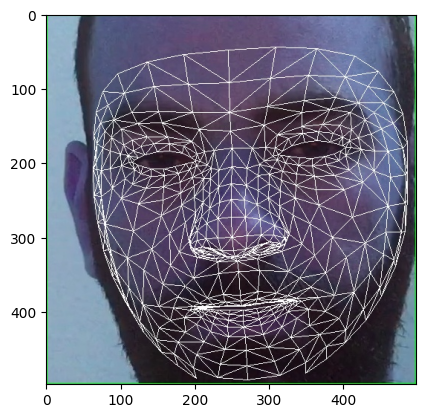

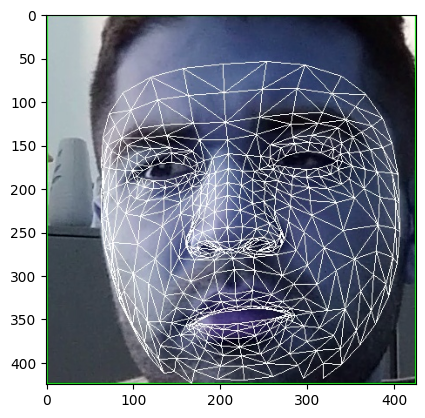

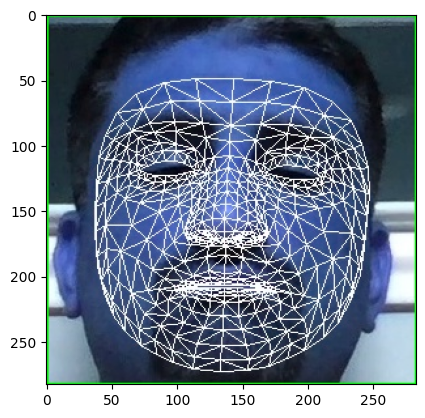

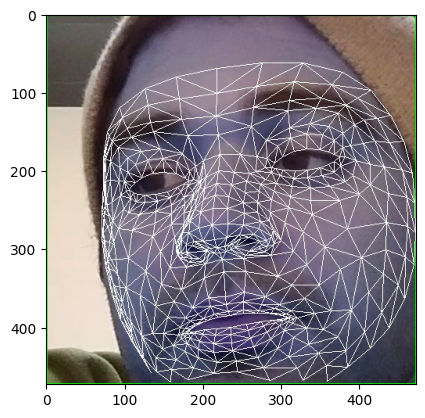

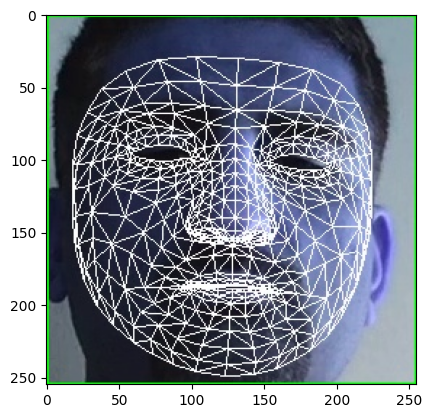

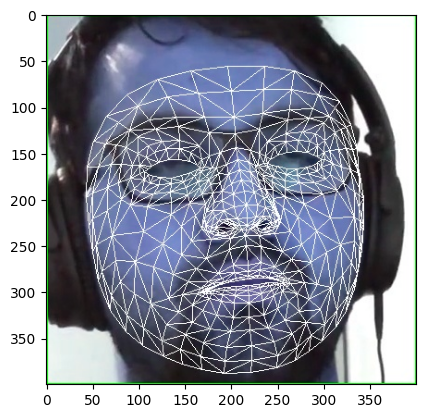

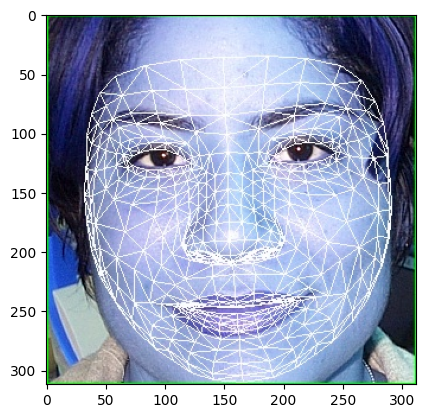

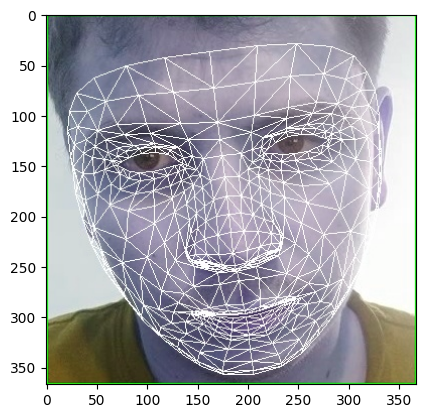

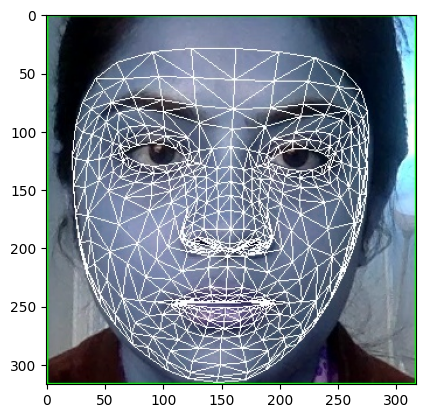

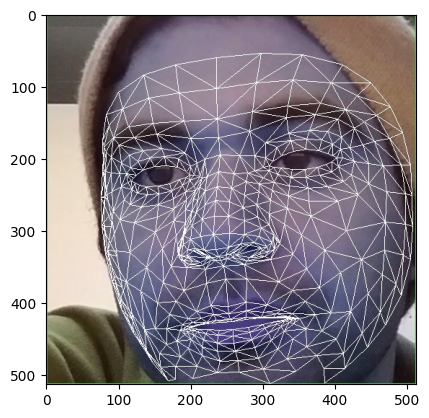

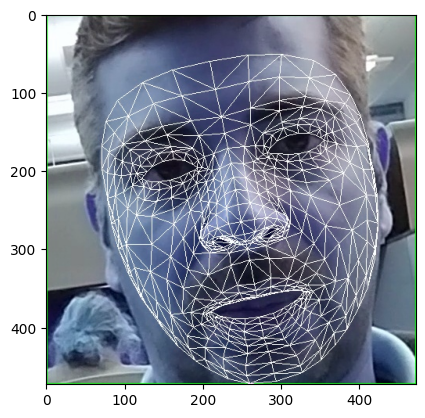

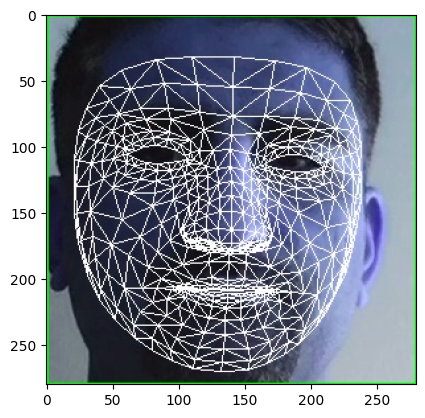

In [ ]:
import matplotlib.pyplot as plt
categories = ["Fatigue Subjects", "Active Subjects"]
for category in categories:
  for idx, img in enumerate(os.listdir(f'./{category}')):
      if idx > 5:
        break
      img_file = cv2.imread(f'./{category}/{img}')
      plt.imshow(img_file)
      plt.show()
      plt.close()

resizing images


In [ ]:
import os
import time
def face_for_yawn(direc="./"):
    yaw_no=[]
    i=1
    IMG_SIZE = 145
    categories = ["Fatigue Subjects", "Active Subjects"]
    for category in categories:
        path_link = os.path.join(direc, category)
        class_num1 = categories.index(category)
        print(class_num1)
        for image in os.listdir(path_link):
            image_array = cv2.imread(os.path.join(path_link, image), cv2.IMREAD_COLOR)
            resized_array = cv2.resize(image_array, (IMG_SIZE, IMG_SIZE))
            yaw_no.append([resized_array, class_num1])
                #print('image face number '+str(i))
                #i=i+1
    return yaw_no
yawn_no_yawn = face_for_yawn()

0
1


Seperate label and features


In [ ]:
X = []
y = []
for feature, label in yawn_no_yawn:
    X.append(feature)
    y.append(label)

Reshape the array

In [ ]:
X = np.array(X)
X = X.reshape(-1, 145, 145, 3)

Label encoder

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_bin = LabelEncoder()
y = label_bin.fit_transform(y)
y = np.array(y)

Splitting

In [ ]:
from sklearn.model_selection import train_test_split
seed = 42
test_size = 0.20
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size)

In [ ]:
len(X_test)

1508

In [ ]:
len(X_train)

6030

In [ ]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

Data Augmentation

In [ ]:
train_generator = ImageDataGenerator(rescale=1/255, zoom_range=0.2, horizontal_flip=True, rotation_range=30)
test_generator = ImageDataGenerator(rescale=1/255)

train_generator = train_generator.flow(np.array(X_train), y_train, shuffle=False)
test_generator = test_generator.flow(np.array(X_test), y_test, shuffle=False)

Model


In [ ]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, BatchNormalization, Dropout, GlobalAveragePooling2D, Flatten
)
from tensorflow.keras.optimizers import Adam

# Define the MobileNet as the base model
base_model = MobileNet(
    weights='imagenet',  # Use pre-trained weights
    include_top=False,   # Exclude fully connected layers
    input_shape=(145, 145, 3)
)

# Freeze the base model layers to use them as feature extractors
base_model.trainable = False

# Build the custom model on top of MobileNet
model_input = Input(shape=(145, 145, 3))
x = base_model(model_input)
x = GlobalAveragePooling2D()(x)

# Fully connected layers
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)

# Output layer
output = Dense(1, activation='sigmoid')(x)

# Create the final model
model = Model(inputs=model_input, outputs=output)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Display the model summary
model.summary()


<ipython-input-22-44cda34c49c2>:9: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 145, 145, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenet_1.00_224 (Functional)      │ (None, 4, 4, 1024)          │       3,228,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,369,153 (12.85 MB)

 Trainable params: 139,905 (546.50 KB)

 Non-trainable params: 3,229,248 (12.32 MB)

In [ ]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, BatchNormalization, Dropout, GlobalAveragePooling2D, Flatten
)
from tensorflow.keras.optimizers import Adam

# Define the MobileNet as the base model
base_model = MobileNet(
    weights='imagenet',  # Use pre-trained weights
    include_top=False,   # Exclude fully connected layers
    input_shape=(145, 145, 3)
)

# Freeze the base model layers to use them as feature extractors
base_model.trainable = False

# Build the custom model on top of MobileNet
model_input = Input(shape=(145, 145, 3))
x = base_model(model_input)
x = GlobalAveragePooling2D()(x)

# Fully connected layers
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)

# Output layer
output = Dense(1, activation='sigmoid')(x)

# Create the final model
model = Model(inputs=model_input, outputs=output)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Display the model summary
model.summary()


<ipython-input-23-44cda34c49c2>:9: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 145, 145, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenet_1.00_224 (Functional)      │ (None, 4, 4, 1024)          │       3,228,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,369,153 (12.85 MB)

 Trainable params: 139,905 (546.50 KB)

 Non-trainable params: 3,229,248 (12.32 MB)

In [24]:
# Train the model
history = model.fit(
    train_generator,
    epochs=70,
    validation_data=test_generator
)

# Save the trained model
model.save('mobileNet_finetuned_model.h5')


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/70
189/189 ━━━━━━━━━━━━━━━━━━━━ 178s 918ms/step - accuracy: 0.5946 - loss: 0.7789 - val_accuracy: 0.7540 - val_loss: 0.4882
Epoch 2/70
189/189 ━━━━━━━━━━━━━━━━━━━━ 193s 873ms/step - accuracy: 0.7181 - loss: 0.6050 - val_accuracy: 0.7752 - val_loss: 0.4598
Epoch 3/70
189/189 ━━━━━━━━━━━━━━━━━━━━ 163s 863ms/step - accuracy: 0.7421 - loss: 0.5412 - val_accuracy: 0.7878 - val_loss: 0.4698
Epoch 4/70
189/189 ━━━━━━━━━━━━━━━━━━━━ 179s 948ms/step - accuracy: 0.7570 - loss: 0.5092 - val_accuracy: 0.7944 - val_loss: 0.4348
Epoch 5/70
189/189 ━━━━━━━━━━━━━━━━━━━━ 173s 914ms/step - accuracy: 0.7728 - loss: 0.4925 - val_accuracy: 0.8037 - val_loss: 0.4110
Epoch 6/70
189/189 ━━━━━━━━━━━━━━━━━━━━ 163s 865ms/step - accuracy: 0.7805 - loss: 0.4708 - val_accuracy: 0.8156 - val_loss: 0.3944
Epoch 7/70
189/189 ━━━━━━━━━━━━━━━━━━━━ 163s 865ms/step - accuracy: 0.7672 - loss: 0.4717 - val_accuracy: 0.8196 - val_loss: 0.4036
Epoch 8/70
189/189 ━━━━━━━━━━━━━━━━━━━━ 165s 871ms/step - accuracy: 0.7997 -

Testing


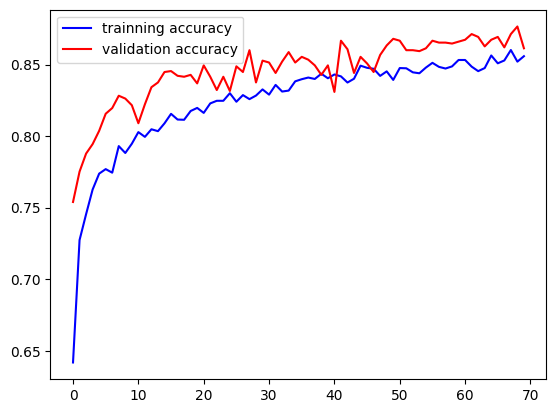

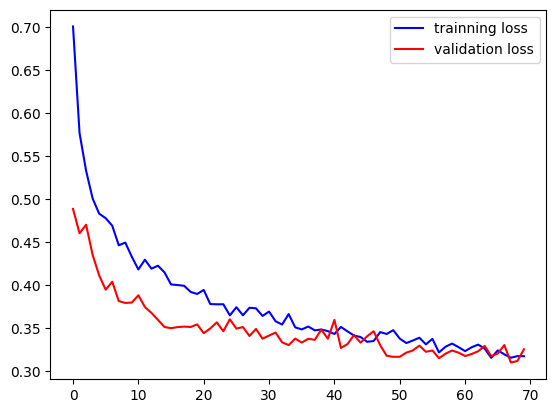

In [25]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, "b", label="trainning accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss, "b", label="trainning loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.show()

In [26]:
# You can evaluate or predict on a dataset.
print("Evaluate")
result = model.evaluate(test_generator)
dict(zip(model.metrics_names, result))

Evaluate
48/48 ━━━━━━━━━━━━━━━━━━━━ 29s 598ms/step - accuracy: 0.8528 - loss: 0.3316


{'loss': 0.3250592052936554, 'compile_metrics': 0.8614058494567871}

In [27]:
model.save('my_model.h5')
#model = tf.keras.models.load_model('my_model.h5')

TEST THE MODEL ON IMAGES FROM WEB


In [28]:
import cv2
import numpy as np
from tensorflow import keras
import urllib.request
import matplotlib.pyplot as plt

In [29]:
model = keras.models.load_model('my_model.h5')

In [40]:
IMG_SIZE = 145
image_url = 'https://thumbs.dreamstime.com/b/tired-man-car-sleepy-drowsy-driver-fatigue-driving-sleeping-vehicle-exhausted-bored-drunk-person-serious-upset-331634548.jpg?w=768'
req = urllib.request.urlopen(image_url)
arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
image = cv2.imdecode(arr, -1)
image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
image = image / 255.0
image = np.expand_dims(image, axis=0)

In [41]:
prediction = model.predict(image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


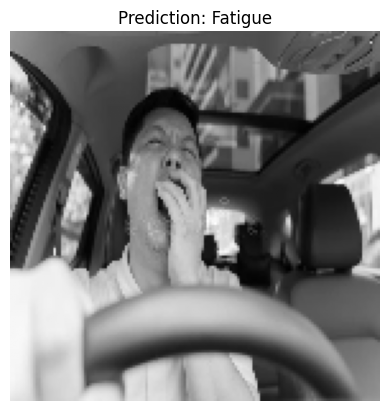

In [43]:
plt.imshow(cv2.cvtColor(cv2.resize(cv2.imdecode(arr, -1), (IMG_SIZE, IMG_SIZE)), cv2.COLOR_BGR2GRAY), cmap='gray')
plt.title(f'Prediction: {"Fatigue" if prediction[0][0] < 0.5 else "Active"}')
plt.axis('off')
plt.show()


In [50]:
IMG_SIZE = 145
image_url = 'https://photos.peopleimages.com/picture/202310/2955857-fitness-city-portrait-and-woman-exercise-determined-and-ready-for-outdoor-cardio-workout-commitment-or-sports.-sweaty-face-road-and-active-athlete-runner-or-person-for-street-training-challenge-zoom_90.jpg'
req = urllib.request.urlopen(image_url)
arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
image = cv2.imdecode(arr, -1)
image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
image = image / 255.0
image = np.expand_dims(image, axis=0)

In [49]:
prediction = model.predict(image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


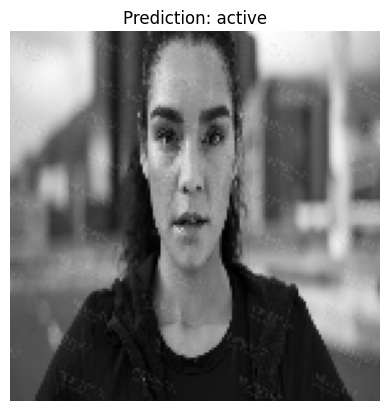

In [52]:
import matplotlib.pyplot as plt
import cv2
gray_image = cv2.cvtColor(cv2.resize(cv2.imdecode(arr, -1), (IMG_SIZE, IMG_SIZE)), cv2.COLOR_BGR2GRAY)

plt.imshow(gray_image, cmap="gray")
plt.title(f'Prediction: {"active" if prediction[0][0] < 0.5 else "fatigue"}')
plt.axis('off')
plt.show()
